# Some take-ways from this notebook

Greedy strategy can be perfectly and easily approximated by a neural network;
However, greedy strategy itself is sub-optimal compared to Dijkstra; the 
algorithm can easily be stuck in a cycle, leading to bad results.

One thing that is a bit concerning is that the graph is small; the network
tends to memorize the entire graph; some experiments on much bigger graphs
should be conducted to verify that the network is actually learning something
useful.

It would be very interesting to see to what extent can Dijkstra be approximated.

# Validate on new graphs

A model that is trained on one random graph
should and indeed can be used to infer paths
on another random graph. This, to some extent,
proves that the network has gained some knowledge,
which is good news.
In this case, the knowledge is the greedy strategy,
i.e., always go with the edge that has the smallest
weight.

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx
import logging
from sklearn.metrics import accuracy_score
from utils import generate_low_degree_g

In [2]:
G = generate_low_degree_g()
print(G.number_of_nodes())
print(G.number_of_edges())

20
58


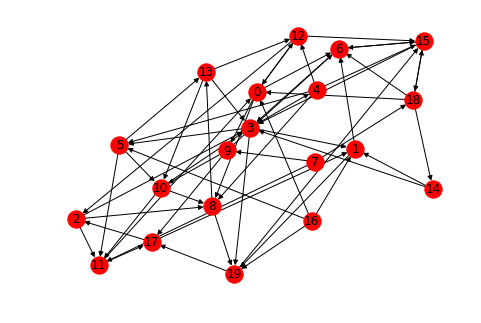

In [3]:
nx.draw(G, with_labels=True)
plt.show()

In [4]:
max_out_degree = max(G.out_degree, key=lambda d: d[1])[1]
max_out_degree

4

In [12]:
def one_hot_encode(idx, length=max_out_degree):
    
    ret = np.zeros(length)
    ret[idx] = 1.0
    return ret

def generate_dataset(G):
    
    X, y = [], []
    
    for node in G.nodes:

        if G.out_degree(node) == 0:
            print('Node %d has 0 out degree' % node)
            continue

        init_weight_vec = np.ones(max_out_degree)

        for idx, out_edge in enumerate(G.out_edges(node)):
            init_weight_vec[idx] = G.get_edge_data(node, out_edge[1])['weight']

        out_neighbors = map(lambda t: (t[1], G.get_edge_data(node, t[1])['weight']),  G.out_edges(node))
    #     print(node, min(out_neighbors, key=lambda d: d[1]), len(out_neighbors), sorted(out_neighbors))

    #     label = one_hot_encode(np.argmin(init_weight_vec, axis=0))
        label = min(out_neighbors, key=lambda d: d[1])[1]
    #     print(label, init_weight_vec[np.argmin(init_weight_vec)])
        assert label == init_weight_vec[np.argmin(init_weight_vec)]
        X.append(init_weight_vec)
        y.append(label)
    
    return np.array(X), np.array(y)

features, labels = generate_dataset(G)
print(features.shape)
print(labels.shape)

(20, 4)
(20,)


In [15]:
def augment_dataset(X, y=None, augmentation_index=600):
    
    X_aug, y_aug = [], []
    indices = np.arange(len(X[0]))
    
    for _, x in enumerate(X):
        for _ in range(augmentation_index):
            np.random.shuffle(indices)
            
            X_aug.append(x[indices])
            y_aug.append(one_hot_encode(np.argmin(x[indices])))
            
    return np.array(X_aug), np.array(y_aug)

def augment_dataset_extend_features(X, y=None, augmentation_index=600):
    pass

In [17]:
X_aug, y_aug = augment_dataset(features, labels, augmentation_index=600)
print(X_aug.shape)
print(y_aug.shape)
print(X_aug[0])
print(y_aug[0])

(12000, 4)
(12000, 4)
[ 0.65048797  0.62600095  0.60809362  0.56853991]
[ 0.  0.  0.  1.]


In [18]:
indices = np.arange(len(X_aug))
np.random.shuffle(indices)
X, y =  X_aug[indices], y_aug[indices]
print(X.shape)
print(y.shape)

(12000, 4)
(12000, 4)


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10800, 4)
(10800, 4)
(1200, 4)
(1200, 4)


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [20]:
batch_size = 100

train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X_test, y_test, batch_size=len(y_test))

In [22]:
def build_model(context=mx.gpu()):
    
    data = mx.sym.var('data')
    label = mx.sym.var('softmax_label')
    
    fc2  = mx.sym.FullyConnected(data=data, num_hidden=32)
    fc2 = mx.sym.Activation(data=fc2, act_type="relu")
    
    fc3  = mx.sym.FullyConnected(data=fc2, num_hidden=max_out_degree)
    mlp  = mx.sym.SoftmaxOutput(data=fc3, label=label)
    
    return mx.mod.Module(symbol=mlp, context=context)

In [23]:
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
model = build_model()
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params()

In [24]:
def custom_acc(label, pred):
    tmp_label = np.argmax(label, axis=1)
    tmp_pred = np.argmax(pred, axis=1)
    return accuracy_score(tmp_label, tmp_pred)

custom_metric = mx.metric.create(custom_acc)

In [26]:
model.fit(train_iter,  # train data
              eval_data=val_iter,  # validation data
              optimizer='adam',  # use SGD to train
#               optimizer_params={'learning_rate':0.01, 'momentum': 0.9},
              eval_metric=custom_metric,  # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 10), # output progress for each 100 data batches
              num_epoch=10)  # train for at most 10 dataset passes

/mxnet/python/mxnet/module/base_module.py:464: UserWarning: Parameters already initialized and force_init=False. init_params call ignored.
  allow_missing=allow_missing, force_init=force_init)
INFO:root:Epoch[0] Batch [10]	Speed: 86220.94 samples/sec	custom_acc=0.390000
INFO:root:Epoch[0] Batch [20]	Speed: 75952.12 samples/sec	custom_acc=0.569000
INFO:root:Epoch[0] Batch [30]	Speed: 119717.54 samples/sec	custom_acc=0.809000
INFO:root:Epoch[0] Batch [40]	Speed: 127161.78 samples/sec	custom_acc=0.815000
INFO:root:Epoch[0] Batch [50]	Speed: 125864.36 samples/sec	custom_acc=0.901000
INFO:root:Epoch[0] Batch [60]	Speed: 128766.28 samples/sec	custom_acc=0.922000
INFO:root:Epoch[0] Batch [70]	Speed: 126984.68 samples/sec	custom_acc=0.943000
INFO:root:Epoch[0] Batch [80]	Speed: 125251.71 samples/sec	custom_acc=0.966000
INFO:root:Epoch[0] Batch [90]	Speed: 107295.90 samples/sec	custom_acc=0.976000
INFO:root:Epoch[0] Batch [100]	Speed: 91315.51 samples/sec	custom_acc=0.988000
INFO:root:Epoch[0] 

In [30]:
pred_train = np.argmax(model.predict(mx.io.NDArrayIter(X_train, y_train, batch_size=len(y_train))).asnumpy(), axis=1)
print('Acc on training set %f' % accuracy_score(np.argmax(y_train, axis=1), pred_train))

pred_test = np.argmax(model.predict(mx.io.NDArrayIter(X_test, y_test, batch_size=len(y_test))).asnumpy(), axis=1)
print('Acc on test set %f' % accuracy_score(np.argmax(y_test, axis=1), pred_test))

Acc on training set 1.000000
Acc on test set 1.000000


In [31]:
def infer_next_node(G, cur_node):
#     print("In infer_next_node")
    return min(map(lambda t: (t[1], G.get_edge_data(cur_node, t[1])['weight']),  G.out_edges(cur_node)), key=lambda d:d[1])

def nn_infer_next_node(G, cur_node, model):
#     print("In nn_infer_next_node")
    input_vec = np.ones(4)
    
    for idx, out_edge in enumerate(G.out_edges(cur_node)):
        input_vec[idx] = G.get_edge_data(cur_node, out_edge[1])['weight']
    
    
    out_neighbors = map(lambda t: (t[1], G.get_edge_data(cur_node, t[1])['weight']),  G.out_edges(cur_node))
    
    pred_idx = np.argmax(model.predict(mx.io.NDArrayIter(np.array([input_vec]), np.array([0]))).asnumpy()[0])
    return out_neighbors[pred_idx]

def greedy_path_finder(G, src, dst, use_nn=False, model=None):
    
    path = [src]
    cur_node = src
    total_weights = .0
    
    while True:
        
        if len(path) >= G.number_of_nodes():
            return path, total_weights, False
        
        next_node, weight = nn_infer_next_node(G, cur_node, model) if use_nn else infer_next_node(G, cur_node)
        total_weights += weight
        path.append(next_node)
        
        if next_node == dst:
            return path, total_weights, True
        
        cur_node = next_node

In [32]:
src, dst = 9, 2

print greedy_path_finder(G, src, dst)
print greedy_path_finder(G, src, dst, use_nn=True, model=model)

([9, 10, 8, 13, 10, 8, 13, 10, 8, 13, 10, 8, 13, 10, 8, 13, 10, 8, 13, 10], 9.317845612754665, False)
([9, 10, 8, 13, 10, 8, 13, 10, 8, 13, 10, 8, 13, 10, 8, 13, 10, 8, 13, 10], 9.317845612754665, False)


In [33]:
nx.dijkstra_path(G, src, dst)

[9, 17, 2]

In [34]:
def check_greedy_path_finder_acc(G, model):
    
    basic_stat = [0, 0, 0, 0]
    extra_stat = {'eq':0, 'path_more':0, 'nn_path_more':0}
    
    for src in G.nodes:
        for dst in G.nodes:
            
            if src == dst:
                continue
            
            path, _, found = greedy_path_finder(G, src, dst)
            nn_path, _, nn_found = greedy_path_finder(G, src, dst, use_nn=True, model=model)
            
            if found == nn_found and found == True:
                basic_stat[0] += 1
                
                if path == nn_path:
                    extra_stat['eq'] += 1
                elif len(path) < len(nn_path):
                    extra_stat['nn_path_more'] += 1
                elif len(path) > len(nn_path):
                    extra_stat['path_more'] += 1
                else:
#                     assert False
                    print 'greedy_path_finder', path
                    print 'nn_greedy_path_finder', nn_path
                
            elif found == nn_found and found == False:
                basic_stat[1] += 1
            elif found == True and nn_found == False:
                basic_stat[2] += 1
            elif found == False and nn_found == True:
                print src, dst
                print 'greedy_path_finder', path
                print 'nn_greedy_path_finder', nn_path
                basic_stat[3] += 1
            else:
                assert False
    
    return basic_stat, extra_stat

In [ ]:
G_1 = generate_low_degree_g()
print(G_1.number_of_nodes())
print(G_1.number_of_edges())
basic_stat, extra_stat = check_greedy_path_finder_acc(G_1, model)
print(map(lambda d: float(d)/sum(basic_stat), basic_stat))
print(extra_stat)

20
59
[0.2868421052631579, 0.7131578947368421, 0.0, 0.0]
{'path_more': 0, 'eq': 109, 'nn_path_more': 0}


In [51]:
# Check the correctness of my_dijkstra_path

for src in G_1.nodes():
    
    paths = nx.single_source_dijkstra_path(G_1, src)
    
    for dst, path in paths.items():
        assert path == my_dijkstra_path(G_1, src, dst)[0]

In [61]:
src, dst = 10, 1
# print(nx.dijkstra_path(G_1, src, dst))
print(my_dijkstra_path(G_1, src, dst)[0])

[10, 1]


In [62]:
my_dijkstra_path(G_1, src, dst)[1]

{0: [[10, 1, 7, 8, 0]],
 1: [[10, 1]],
 2: [[10, 1, 7, 18, 9, 4, 2]],
 3: [[10, 1, 11, 6, 3]],
 4: [[10, 1, 11, 5, 4], [10, 1, 7, 18, 9, 4]],
 5: [[10, 1, 7, 8, 5], [10, 1, 11, 5]],
 6: [[10, 1, 11, 6]],
 7: [[10, 7], [10, 1, 7]],
 8: [[10, 1, 7, 8]],
 9: [[10, 1, 7, 18, 9]],
 10: [],
 11: [[10, 1, 11]],
 12: [[10, 1, 7, 8, 12], [10, 1, 11, 5, 12]],
 13: [[10, 1, 7, 18, 19, 13]],
 14: [[10, 1, 11, 5, 12, 14], [10, 1, 7, 18, 19, 13, 14]],
 15: [[10, 1, 15]],
 16: [[10, 1, 16]],
 17: [[10, 1, 7, 8, 0, 17]],
 18: [[10, 18], [10, 1, 7, 18]],
 19: [[10, 1, 7, 18, 19]]}